In [1]:
from google.colab import drive
drive.mount("/gdrive")
%cd "gdrive"

Mounted at /gdrive
[Errno 2] No such file or directory: 'gdrive'
/content


In [2]:
import os
os.chdir("/gdrive/MyDrive/big_data")


In [3]:
!pwd

/gdrive/MyDrive/big_data


In [4]:
pip install -q pyspark

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 52.9 MB/s 


In [5]:
from pyspark.sql import SparkSession

In [6]:
sparkSession = SparkSession.builder.appName("spark-mllib").getOrCreate()

In [8]:
bookDS = sparkSession.read.csv(path="/gdrive/MyDrive/big_data/RecommendationApplication/books.csv", header=True, inferSchema=True)

In [9]:
bookDS.show(5)

+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|
+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------

In [10]:
bookDS.printSchema()

root
 |-- id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- work_ratings_count: string (nullable = true)
 |-- work_text_reviews_count: string (nullable = true)
 |-- ratings_1: double (nullable = true)
 |-- ratings_2: integer (nullable = true)
 |-- ratings_3: integer (nullable = true)
 |-- ratings_4: integer (nullable = true)
 |-- ratings_5: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nullable = true)


In [11]:
ratingDS = sparkSession.read.csv(path="/gdrive/MyDrive/big_data/RecommendationApplication/ratings.csv", header=True, inferSchema=True)

In [12]:
ratingDS.show(5)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
+-------+-------+------+
only showing top 5 rows



In [13]:
ratingDS.describe().show()

+-------+-----------------+------------------+------------------+
|summary|          book_id|           user_id|            rating|
+-------+-----------------+------------------+------------------+
|  count|           981756|            981756|            981756|
|   mean|4943.275635697668|25616.759933221696|3.8565335989797873|
| stddev|2873.207414896114|15228.338825882167|0.9839408559620033|
|    min|                1|                 1|                 1|
|    max|            10000|             53424|                 5|
+-------+-----------------+------------------+------------------+



In [14]:
avgratingDS = ratingDS.groupBy("book_id").avg("rating").orderBy("avg(rating)", ascending=False)
avgratingDS.show(5)

+-------+-----------------+
|book_id|      avg(rating)|
+-------+-----------------+
|   7947|4.820224719101123|
|   5207|             4.78|
|   6920|             4.78|
|   9566|4.777777777777778|
|   8946|4.774193548387097|
+-------+-----------------+
only showing top 5 rows



In [15]:
from pyspark.sql.functions import *

In [18]:
#avgratingDS.select("book_id",bround("avg(rating)",2)).withColumnRenamed("bround(avg(rating), 2)","rating").show()
rateDS = avgratingDS.select("book_id", bround("avg(rating)", 2).alias("rating"))

In [19]:
rateDS.show(5)

+-------+------+
|book_id|rating|
+-------+------+
|   7947|  4.82|
|   5207|  4.78|
|   6920|  4.78|
|   9566|  4.78|
|   8946|  4.77|
+-------+------+
only showing top 5 rows



In [20]:
titlebookDS = bookDS.select("book_id", "original_title")

In [21]:
avgBookTitle = titlebookDS.join(rateDS, on="book_id", how="inner")

In [22]:
avgBookTitle.show(5)

+-------+--------------------+------+
|book_id|      original_title|rating|
+-------+--------------------+------+
|   1591|          Λυσιστράτη|  4.01|
|   2122|    The Fountainhead|  3.46|
|   2142|               Blink|  3.74|
|   4900|   Heart of Darkness|  3.65|
|   1990|The Life and Adve...|  3.85|
+-------+--------------------+------+
only showing top 5 rows



In [23]:
filterbookDS = bookDS.filter("original_publication_year is not null AND  original_publication_year > 0")

In [24]:
filterbookDS.select("original_title", "original_publication_year").orderBy("original_publication_year", ascending=True).show(10)

+--------------------+-------------------------+
|      original_title|original_publication_year|
+--------------------+-------------------------+
|       Metamorphoses|                      8.0|
|   De vita Caesarum |                    119.0|
|      Τὰ εἰς ἑαυτόν |                    180.0|
|Confessiones Sanc...|                    397.0|
|القرآن‎‎ [al-Qurʾān]|                    609.0|
|كِتَاب أَلْف لَيْ...|                    800.0|
|             Beowulf|                    975.0|
|رباعیات [Robāʿiāt...|                   1120.0|
|      Essential Rumi|                   1273.0|
|  La Divina Commedia|                   1308.0|
+--------------------+-------------------------+
only showing top 10 rows



# Sql API

In [25]:
filterbookDS.createOrReplaceTempView("books")

In [26]:
sparkSession.sql("select original_publication_year, count(*) from books where original_publication_year > 1960 group by original_publication_year having count(1) > 400").show()


+-------------------------+--------+
|original_publication_year|count(1)|
+-------------------------+--------+
|                   2010.0|     473|
|                   2009.0|     432|
|                   2011.0|     556|
|                   2013.0|     518|
|                   2012.0|     568|
|                   2014.0|     437|
+-------------------------+--------+



# My Examples

In [ ]:
#bookDS.toPandas().to_excel("books.xlsx")

In [ ]:
# bookDS.filter("language_code = 'eng'").count()

In [29]:
# count of null value counts
# bookDS.toPandas().isnull().sum()
for col in bookDS.columns:
  print("{0:25}  {1:4d}".format(col, bookDS.filter(bookDS[col].isNull()).count()))


id                            0
book_id                       0
best_book_id                  0
work_id                       0
books_count                   0
isbn                        700
isbn13                      585
authors                       0
original_publication_year    21
original_title              585
title                         0
language_code              1084
average_rating                0
ratings_count                 0
work_ratings_count            0
work_text_reviews_count       0
ratings_1                     0
ratings_2                     0
ratings_3                     0
ratings_4                     0
ratings_5                     0
image_url                     0
small_image_url               0


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text major ticklabel objects>)

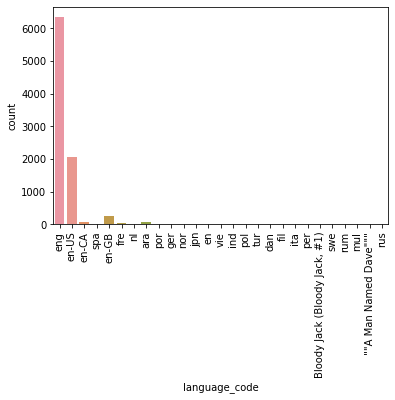

In [35]:
sns.countplot(bookDS.toPandas()["language_code"])
plt.xticks(rotation=90)

In [36]:
bookDS.toPandas().corr()

,id,book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
id,1.000000,0.115154,0.104516,0.113861,-0.263841,-0.011291,0.049875,-0.239392,-0.345643,-0.413246,-0.407087,-0.332494
book_id,0.115154,1.000000,0.966620,0.929356,-0.164578,-0.048246,0.133790,-0.038389,-0.056615,-0.075644,-0.063303,-0.056140
best_book_id,0.104516,0.966620,1.000000,0.899258,-0.159240,-0.047253,0.131442,-0.033908,-0.049329,-0.067024,-0.054455,-0.049520
work_id,0.113861,0.929356,0.899258,1.000000,-0.109436,-0.039320,0.107972,-0.034605,-0.051417,-0.066758,-0.054768,-0.046740
books_count,-0.263841,-0.164578,-0.159240,-0.109436,1.000000,0.017865,-0.321753,0.225757,0.334888,0.383692,0.349567,0.279561
isbn13,-0.011291,-0.048246,-0.047253,-0.039320,0.017865,1.000000,-0.004612,0.006055,0.010350,0.012144,0.010160,0.006621
original_publication_year,0.049875,0.133790,0.131442,0.107972,-0.321753,-0.004612,1.000000,-0.019632,-0.038465,-0.042458,-0.025786,-0.015388
ratings_1,-0.239392,-0.038389,-0.033908,-0.034605,0.225757,0.006055,-0.019632,1.000000,0.926109,0.795354,0.672978,0.597227
ratings_2,-0.345643,-0.056615,-0.049329,-0.051417,0.334888,0.010350,-0.038465,0.926109,1.000000,0.949578,0.838260,0.705717
ratings_3,-0.413246,-0.075644,-0.067024,-0.066758,0.383692,0.012144,-0.042458,0.795354,0.949578,1.000000,0.952994,0.825547


In [37]:
bookDS.groupBy("language_code", "work_id").count().toPandas()

,language_code,work_id,count
0,en-US,4422413,1
1,en-GB,120878,1
2,eng,14893776,1
3,eng,1285373,1
4,eng,912988,1
...,...,...,...
9995,None,42788872,1
9996,None,103828,1
9997,None,1413359,1
9998,None,2747783,1


In [38]:
goodbookDS = ratingDS.withColumn("good", when(ratingDS["rating"] > 3, "True").otherwise("False"))

In [39]:
goodbookDS.show(5)

+-------+-------+------+-----+
|book_id|user_id|rating| good|
+-------+-------+------+-----+
|      1|    314|     5| True|
|      1|    439|     3|False|
|      1|    588|     5| True|
|      1|   1169|     4| True|
|      1|   1185|     4| True|
+-------+-------+------+-----+
only showing top 5 rows



In [40]:
goodbookDS.groupBy("good").count().show()

+-----+------+
| good| count|
+-----+------+
|False|331429|
| True|650327|
+-----+------+



In [41]:
goodbookDS = ratingDS.withColumn("new_rating", ratingDS.rating.cast("float"))
goodbookDS.show()

+-------+-------+------+----------+
|book_id|user_id|rating|new_rating|
+-------+-------+------+----------+
|      1|    314|     5|       5.0|
|      1|    439|     3|       3.0|
|      1|    588|     5|       5.0|
|      1|   1169|     4|       4.0|
|      1|   1185|     4|       4.0|
|      1|   2077|     4|       4.0|
|      1|   2487|     4|       4.0|
|      1|   2900|     5|       5.0|
|      1|   3662|     4|       4.0|
|      1|   3922|     5|       5.0|
|      1|   5379|     5|       5.0|
|      1|   5461|     3|       3.0|
|      1|   5885|     5|       5.0|
|      1|   6630|     5|       5.0|
|      1|   7563|     3|       3.0|
|      1|   9246|     1|       1.0|
|      1|  10140|     4|       4.0|
|      1|  10146|     5|       5.0|
|      1|  10246|     4|       4.0|
|      1|  10335|     4|       4.0|
+-------+-------+------+----------+
only showing top 20 rows

